In [2]:
# https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020?select=rating_complete.csv

In [3]:
import pandas as pd

In [4]:
# prepare a list of anime shows with their synopsis

# load anime shows
pre_merged_anime = pd.read_csv("data/anime.csv").dropna()

# load synopsis for anime shows
synopsis = pd.read_csv("./data/anime_with_synopsis.csv").dropna()

# sql-like join on anime and synopsis
pre_merged_anime = pd.merge(
  pre_merged_anime,
  synopsis,
  how="inner",
  on=["MAL_ID", "Name", "Genres"]
).dropna()

# sql-like select to keep relevant columns
pre_merged_anime = pre_merged_anime[[
  "MAL_ID",
  "Name",
  "Score_x",
  "Genres",
  "English name",
  "Type",
  "Aired",
  "Premiered",
  "Producers",
  "Source",
  "sypnopsis"]]

# rename columns
pre_merged_anime = pre_merged_anime.rename(columns={
  "Score_x": "Score",
  "sypnopsis": "Synopsis"
})

# check results
print(pre_merged_anime.shape)
pre_merged_anime.head(2)

(16206, 11)


,MAL_ID,Name,Score,Genres,English name,Type,Aired,Premiered,Producers,Source,Synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,TV,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,Original,"In the year 2071, humanity has colonized sever..."
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,Movie,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Original,"other day, another bounty—such is the life of ..."


In [5]:
import re
import string

def sanitize(text:str)->str:
  text = ''.join(filter(lambda x: x in string.printable, text))
  text = re.sub(r'\s{2,}',' ', text)
  return text.strip()

def description(show:pd.Series)->str:
  show_type = "TV Show" if show["Type"] == "TV" else show["Type"]
  blurb = '\n'.join([
    f"{show['Name']} is a {show_type}.",
    f"Synopsis: {show['Synopsis']}",
    f"It premiered on {show['Premiered']}.",
    f"Its genres are {show['Genres']}.",
    f"It was produced by {show['Producers']}.",
    f"Its source is {show['Source']}."
  ])
  return sanitize(blurb)



In [6]:
print(description(pre_merged_anime.iloc[0]))

Cowboy Bebop is a TV Show.
Synopsis: In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travelsEin, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wongthe crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Be

In [7]:
# create a new column with the generated description
pre_merged_anime['Description'] = \
  pre_merged_anime.apply(description, axis=1)

In [8]:
watching_status = pd.read_csv("./data/watching_status.csv").dropna()
print(watching_status.shape)
watching_status

(5, 2)


,status,description
0,1,Currently Watching
1,2,Completed
2,3,On Hold
3,4,Dropped
4,6,Plan to Watch


In [9]:
rating_complete = pd.read_csv("./data/rating_complete.csv").dropna()
print(rating_complete.shape)
rating_complete.head(2)

(57633278, 3)


,user_id,anime_id,rating
0,0,430,9
1,0,1004,5


In [10]:
import numpy as np

rating_complete_train, rating_complete_test = \
  np.split(
    rating_complete.sample(frac=1, random_state=42),
    [int(.9*len(rating_complete))]
  )

/Users/nico/pytorch/env/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [11]:
rating_complete_train.head()

,user_id,anime_id,rating
41605545,255419,4059,7
33600014,206382,10793,7
39884414,245012,34246,4
45251042,277697,5030,7
53777062,329602,227,7


In [12]:
print(rating_complete_train.shape)
print(rating_complete_test.shape)

(51869950, 3)
(5763328, 3)


In [13]:
anime_counts = rating_complete_train.groupby('anime_id').count()
anime_counts['user_id'].describe()

count     16865.000000
mean       3075.597391
std        9275.477582
min           1.000000
25%          36.000000
50%         240.000000
75%        1506.000000
max      164244.000000
Name: user_id, dtype: float64

In [14]:
user_counts = rating_complete_train.groupby('user_id').count()
user_counts['anime_id'].describe()

count    309426.000000
mean        167.632810
std         229.910583
min           1.000000
25%          39.000000
50%         102.000000
75%         214.000000
max       13955.000000
Name: anime_id, dtype: float64

In [15]:
!pip install dask dask-ml

In [16]:
score_map = {
  10: 1,
  9: 1,
  8: 0,
  7: 0,
  6: -1,
  5: -1,
  4:-1,
  3:-1,
  2:-1,
  1:-1,
  0:-1
}

In [17]:
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
import itertools
import random

/Users/nico/pytorch/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
def jaccard_similarity(set1:set, set2:set)->float:
  intersection = len(set1.intersection(set2))
  union = len(set1.union(set2))
  if union:
    return intersection / union
  return -1.0

rating_threshold = 9
positive_ratings = \
  rating_complete_train[rating_complete_train["rating"] >= rating_threshold]
user_anime_dict = positive_ratings\
  .groupby('user_id')['anime_id'].apply(set).to_dict()
anime_pairs = itertools.combinations(
  sorted(set(pre_merged_anime['MAL_ID'].unique()) &
         set(rating_complete_train['anime_id'].unique())),
  2
)

In [20]:
from random import sample, seed
from sentence_transformers import InputExample

positive_pairs_examples, negative_pairs_examples = [], []

seed(42)

for a1, a2 in tqdm(anime_pairs):
  if a1 not in pre_merged_anime.index or a2 not in pre_merged_anime.index:
    continue
  j = jaccard_similarity(user_anime_dict.get(a1, set()), user_anime_dict.get(a2, set()))
  if j > 0:
    texts = [
      pre_merged_anime.loc[a1]['Description'],
      pre_merged_anime.loc[a2]['Description']
    ]
    if j >= 0.3:
      positive_pairs_examples.append(InputExample(texts=texts, label=1.))
    elif j < 0.1:
      negative_pairs_examples.append(InputExample(texts=texts, label=0.))
      if len(negative_pairs_examples) > len(positive_pairs_examples) * 5:
        random.shuffle(negative_pairs_examples)
        negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)]



120769111it [07:31, 267579.86it/s] 


In [21]:
positive_pairs_examples[0].__dict__

{'guid': '',
 'texts': ['Sunabouzu is a TV Show.\nSynopsis: The Great Kanto Desert, a sweltering wasteland of nothing but ruins and sand, is all that remains of post-apocalyptic Japan. The once fair population has been left to cling to the inhospitable dunes for survival. At least, that is the case for normal people. For those who have spent a little too long in the Kanto sun, the desert offers a wondrous opportunity to make a name for themselves. One such person is the masked handyman "Sunabouzu," or Desert Punk, who has forged a legendary reputation for always finishing his jobs, no matter the nature or cost. Cunning and ruthless, he has become a force of crude destruction to the other desert people. However, the "Vixen of the Desert," Junko Asagiri, discovers that Sunabouzu is not without his weaknesseshe is easily swayed by his insatiable lust for large-breasted desert babes. Following their chaotic adventures through the Kanto Desert, Sunabouzu features a bizarre cast of personali

In [22]:
len(positive_pairs_examples), len(negative_pairs_examples)

(1567, 4918)

In [23]:
if len(negative_pairs_examples) > len(positive_pairs_examples):
  random.shuffle(negative_pairs_examples)
  negative_pairs_examples = negative_pairs_examples[:len(positive_pairs_examples)]

In [24]:
from sklearn.model_selection import train_test_split

train_positive_pairs, val_positive_pairs = \
  train_test_split(positive_pairs_examples, test_size=0.2, random_state=42)
train_negative_pairs, val_negative_pairs = \
  train_test_split(negative_pairs_examples, test_size=0.2, random_state=42)
 

In [26]:
import torch

from sentence_transformers import SentenceTransformer, evaluation, losses

torch.set_default_device('mps')

SentenceTransformer('paraphrase-distilroberta-base-v1')

/Users/nico/pytorch/env/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/Users/nico/pytorch/env/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [52]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1', device='mps')
model.max_seq_length = 384
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 384, 'do_lower_case': False}) with Transformer model: RobertaModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors


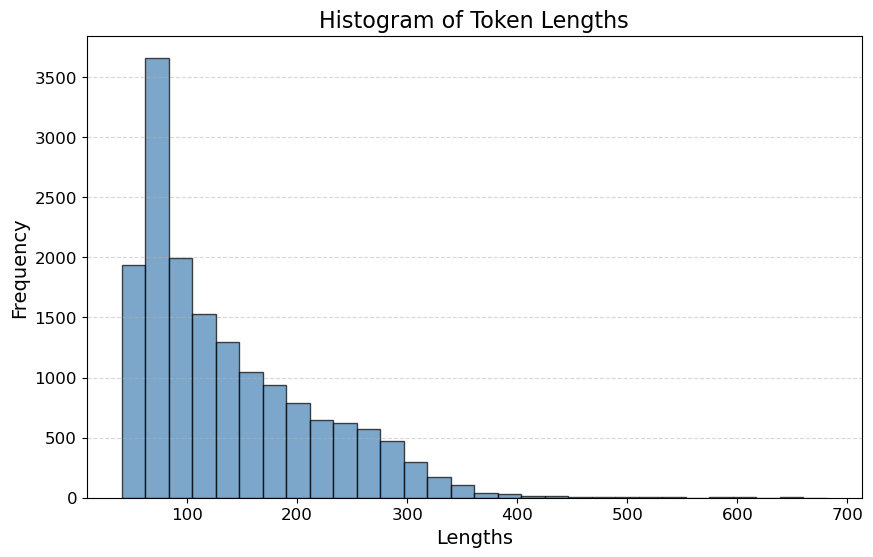

In [44]:
lengths = []

for c in pre_merged_anime['Description']:
  lengths.append(model.tokenizer(c, return_tensors='pt')\
                 ['input_ids'].shape[1])

import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(lengths, bins=30, edgecolor='black', color='steelblue', alpha=0.7)

plt.title('Histogram of Token Lengths', fontsize=16)
plt.xlabel('Lengths', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', alpha=0.5, linestyle='--')

plt.show()

In [45]:
all_examples_val = val_positive_pairs + val_negative_pairs

val_dataloader = DataLoader(
  all_examples_val,
  batch_size=16,
  shuffle=True,
  generator=torch.Generator(device='mps')
)

loss = losses.CosineSimilarityLoss(model=model)
loss.to('mps')

val_sentences1 = [ex.texts[0] for ex in all_examples_val]
val_sentences2 = [ex.texts[1] for ex in all_examples_val]
val_scores = [ex.label for ex in all_examples_val]

evaluator = evaluation.EmbeddingSimilarityEvaluator(
  val_sentences1,
  val_sentences2,
  val_scores
)

In [46]:
t = SentenceTransformer('paraphrase-distilroberta-base-v1', device='mps')
t.evaluate(evaluator)

-0.19633072707560364

In [47]:
model.evaluate(evaluator)

-0.02831828311076173

In [54]:
import torch
torch.set_default_device('mps')

train_examples = train_positive_pairs + train_negative_pairs

train_dataloader = DataLoader(
  train_examples,
  batch_size=64,
  shuffle=True,
  generator=torch.Generator(device='mps')
)

loss = losses.CosineSimilarityLoss(model=model)
loss = loss.to('mps')

num_epochs = 5

warmup_steps = int(
  len(train_dataloader) *
  num_epochs * 0.1
)

model.fit(
  train_objectives=[(train_dataloader, loss)],
  epochs=num_epochs,
  warmup_steps=warmup_steps,
  evaluator=evaluator,
  output_path="anime_encoder",
  save_best_model=False,
  show_progress_bar=True

)

Epoch: 100%|██████████| 5/5 [14:38<00:00, 175.79s/it]


In [55]:
model.evaluate(evaluator)

0.8429783705663847

In [56]:
model.save("anime_encoder")

TypeError: Object of type method is not JSON serializable

In [58]:
embedders = ('anime_encoder')

embeddings = {}

In [65]:
from tqdm.auto import tqdm

from sentence_transformers import SentenceTransformer

docs = pre_merged_anime['Description'].to_list()
e = model
embeddings['anime_encoder'] = e.encode(
  docs,
  batch_size=128,
  show_progress_bar=True
)



Batches: 100%|██████████| 127/127 [00:54<00:00,  2.32it/s]


In [66]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity_matrix = \
  cosine_similarity(embeddings['anime_encoder'])

In [68]:
import functools
from typing import List, Tuple


@functools.lru_cache(maxsize=None)
def findSimilarAnime(anime_id:int,
                     embedder:str = 'anime_encoder',
                     k: int = 10,
                     verbose: bool = False)\
                     -> List[Tuple[int, float]]:
  try:
    idx = pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id].index[0]
  except:
    return []
  if verbose:
    print(f"idx:{idx}")
  similarity_scores = list(enumerate(cosine_similarity_matrix[idx]))
  similarity_scores = sorted(similarity_scores,
                             key=lambda x: x[1],
                             reverse=True)
  k_indices_scores = similarity_scores[1:k+1]
  k_indices = [i[0] for i in k_indices_scores]
  k_scores = [round(i[1],3) for i in k_indices_scores]
  k_anime_ids = pre_merged_anime['MAL_ID'].iloc[k_indices].tolist()
  return list(zip(k_anime_ids, k_scores))

In [69]:
anime_id = 4059
k = 10
similar_animes = findSimilarAnime(anime_id=anime_id)
print(similar_animes)

[(2167, 0.958), (2494, 0.957), (18599, 0.956), (62, 0.956), (2559, 0.954), (21647, 0.954), (1588, 0.954), (1478, 0.954), (45055, 0.953), (133, 0.953)]


In [72]:
def promotedAnimesFor(user_id:str)->[str]:
  return rating_complete_train[
    (rating_complete_train['user_id'] == user_id) &
    (rating_complete_train['rating'] >= 9)]['anime_id'].tolist()


In [73]:
def getRecommendedAnime(reference_anime_id:str,
                        verbose:bool=True)->[(str,float)]:
  recommended = []
  similar_animes = findSimilarAnime(anime_id=reference_anime_id)
  for anime_id, cosine_score in similar_animes:
    if cosine_score >= 1:
      continue
    if verbose:
      print(f"Recommending ID {anime_id} Similarity {cosine_score:.3f}")
      recommended.append((anime_id, cosine_score))
  return recommended

In [74]:
from collections import defaultdict
user_id = 205282
user_predictions = defaultdict(float)
for anime in set(promotedAnimesFor(user_id)):
  recommended_animes = findSimilarAnime(anime)
  for anime_id, similarity_score in recommended_animes:
    if anime_id not in user_predictions or \
      similarity_score > user_predictions[anime_id]:
      user_predictions[anime_id] = similarity_score

user_predictions

defaultdict(float,
            {930: 0.974,
             2001: 0.982,
             2598: 0.985,
             516: 0.969,
             1069: 0.968,
             573: 0.967,
             237: 0.981,
             4242: 0.966,
             180: 0.978,
             400: 0.972,
             269: 0.985,
             9513: 0.982,
             1482: 0.986,
             4898: 0.983,
             13663: 0.982,
             31933: 0.981,
             859: 0.976,
             278: 0.975,
             1194: 0.975,
             937: 0.975,
             1002: 0.975,
             32071: 0.973,
             567: 0.972,
             227: 0.972,
             1064: 0.972,
             3154: 0.971,
             182: 0.981,
             2722: 0.971,
             1751: 0.971,
             8074: 0.979,
             25099: 0.978,
             8277: 0.977,
             24873: 0.977,
             17513: 0.977,
             29976: 0.976,
             23945: 0.982,
             11499: 0.98,
             35248: 0.97

In [76]:
print(f"predicting anime for user {user_id}")
sample = list(user_predictions.keys())[:3]
for anime_id in sample:
  print(pre_merged_anime[pre_merged_anime['MAL_ID'] == anime_id]['Name'].to_string())

predicting anime for user 205282
821    Densetsu Kyojin Ideon
1740    Tengen Toppa Gurren Lagann
2198    Juusenki L-Gaim
